In [1]:
import numpy as np

from utils import *

在这次练习中，将会使用K-means算法来进行图像压缩。

# Visualizing Data

In [2]:
raw_data = loadmat('data/ex7data2.mat')
raw_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Nov 16 00:48:22 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 1.84207953,  4.6075716 ],
        [ 5.65858312,  4.79996405],
        [ 6.35257892,  3.2908545 ],
        [ 2.90401653,  4.61220411],
        [ 3.23197916,  4.93989405],
        [ 1.24792268,  4.93267846],
        [ 1.97619886,  4.43489674],
        [ 2.23454135,  5.05547168],
        [ 2.98340757,  4.84046406],
        [ 2.97970391,  4.80671081],
        [ 2.11496411,  5.37373587],
        [ 2.12169543,  5.20854212],
        [ 1.5143529 ,  4.77003303],
        [ 2.16979227,  5.27435354],
        [ 0.41852373,  4.88312522],
        [ 2.47053695,  4.80418944],
        [ 4.06069132,  4.99503862],
        [ 3.00708934,  4.67897758],
        [ 0.66632346,  4.87187949],
        [ 3.1621865 ,  4.83658301],
        [ 0.51155258,  4.91052923],
        [ 3.1342801 ,  4.96178114],
        [ 2.04974595,  5.6241395 ],
        [ 0.66582785,  5.243

In [3]:
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
X = raw_data['X']
data.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


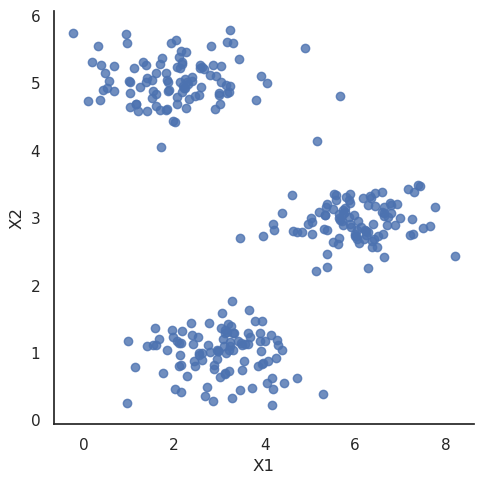

In [4]:
sns.set_theme(context='notebook', style='white')
sns.lmplot(x='X1', y='X2', data=data, fit_reg=False)
plt.show()

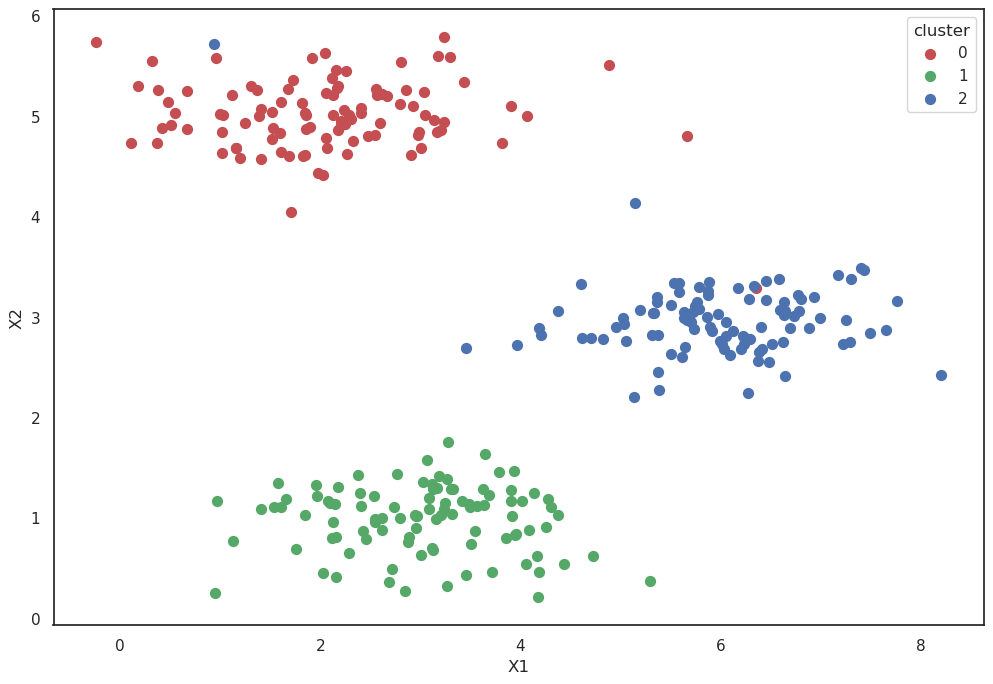

In [5]:
data2_1 = data[:100]
data2_2 = data[101:200]
data2_3 = data[201:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(data2_1['X1'], data2_1['X2'], s=50, color='r', edgecolors='r', label='0')
ax.scatter(data2_2['X1'], data2_2['X2'], s=50, color='g', edgecolors='g', label='1')
ax.scatter(data2_3['X1'], data2_3['X2'], s=50, color='b', edgecolors='b', label='2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend(loc='best', title='cluster')
plt.show()

# [Understanding K-means Clustering](https://www.geeksforgeeks.org/k-means-clustering-introduction/)

K-means clustering is a technique used to organize data into groups **based on their similarity**.For example online store uses K-Means to group customers based on purchase frequency and spending creating segments like Budget Shoppers, Frequent Buyers and Big Spenders for personalised marketing.

## How k-means clustering works?

1. 随机初始化k个点叫做均值(means)或者聚类质心(cluster centroids).
2. 将每个类归为其最接近的mean，更新mean的坐标，
3. 重复

## Init Clusters

使用np.random.choice随机抽样是K-means初始化随机聚类中心的标准方法

In [6]:
def init_cluster(X, k):
    center = X[np.random.choice(X.shape[0], k, replace=False)]
    clusters = [{'center': c, 'points': [] } for c in center]
    return clusters

In [7]:
test_cluster = init_cluster(X, 3)
test_cluster

[{'center': array([0.94048944, 5.71556802]), 'points': []},
 {'center': array([1.5143529 , 4.77003303]), 'points': []},
 {'center': array([1.53178107, 1.10054852]), 'points': []}]

In [8]:
def draw_init_cluster(clusters):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(data2_1['X1'], data2_1['X2'], s=50, color='r', edgecolors='r', label='0')
    ax.scatter(data2_2['X1'], data2_2['X2'], s=50, color='g', edgecolors='g', label='1')
    ax.scatter(data2_3['X1'], data2_3['X2'], s=50, color='b', edgecolors='b', label='2')

    for it in clusters:
        center = it['center']
        plt.scatter(center[0], center[1], s=70, marker='^', c='#FFFF00')
    plt.scatter([], [], s=70, marker='^', c='#FFFF00', edgecolor='black', label='Centroid')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 6)
    ax.legend(loc='best', title='cluster')
    plt.show()

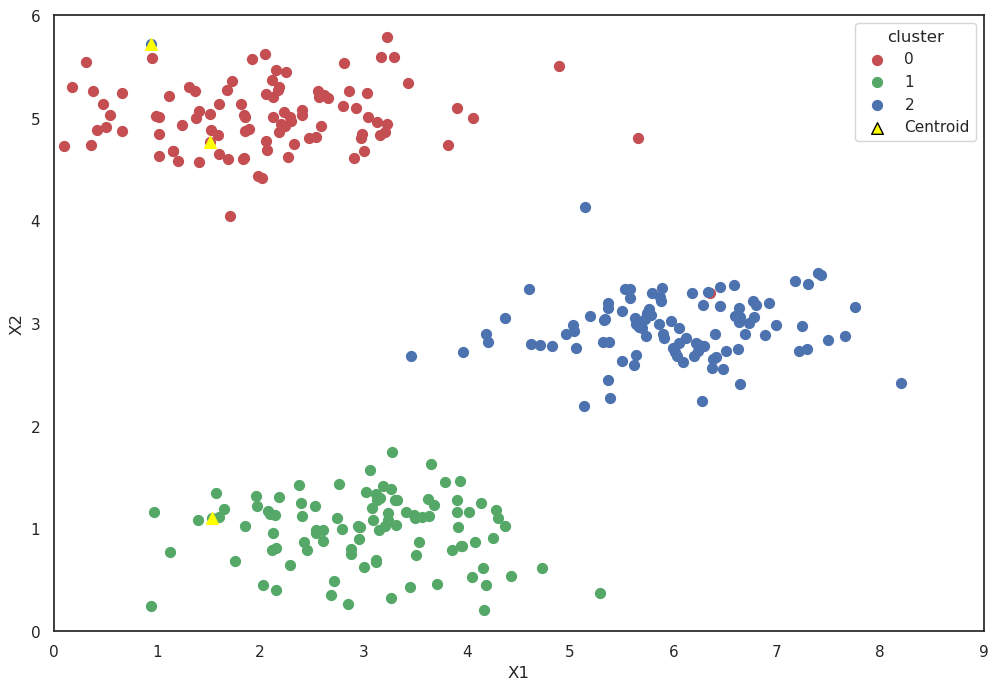

In [9]:
draw_init_cluster(test_cluster)

## Define Euclidean distance

计算每个样本点离聚类中心点距离

$$
c^{(i)} := j \ that\ minimizes \ ||x^{(i)} - \mu_j||^2
$$

计算新的聚类中心点
$$
\mu_k := \frac{1}{|C_k|}\sum_{i\in C_k}x^{(i)}
$$

In [10]:
# def distance(p1,p2):
    # return np.sqrt(np.sum((p1-p2)**2))
def distance(a, b):
    return np.linalg.norm(a - b)

## Create the function to Assign and Update the cluster center

In [11]:
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []

        curr_x = X[idx]

        for it in clusters:
            dist.append(distance(curr_x, it['center']))
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters

def update_clusters(clusters):
    for it in clusters:
        points = np.array(it['points'])
        if points.size > 0:
            it['center'] = points.mean(axis=0)
            it['points'] = []
    return clusters

def kmenas(X, k, max_iter=100, show_start=False):
    clusters = init_cluster(X, k)
    start = np.array([c['center'] for c in clusters])
    if show_start:
        draw_init_cluster(clusters)
    centroids = [c['center'] for c in clusters]

    for _ in range(max_iter):
        old_centers = [c['center'] for c in clusters]
        clusters = assign_clusters(X, clusters)
        clusters = update_clusters(clusters)
        new_centers = [c['center'] for c in clusters]
        centroids += new_centers
        if np.allclose(old_centers, new_centers):
            break
    end = np.array([c['center'] for c in clusters])
    return clusters, centroids, start, end

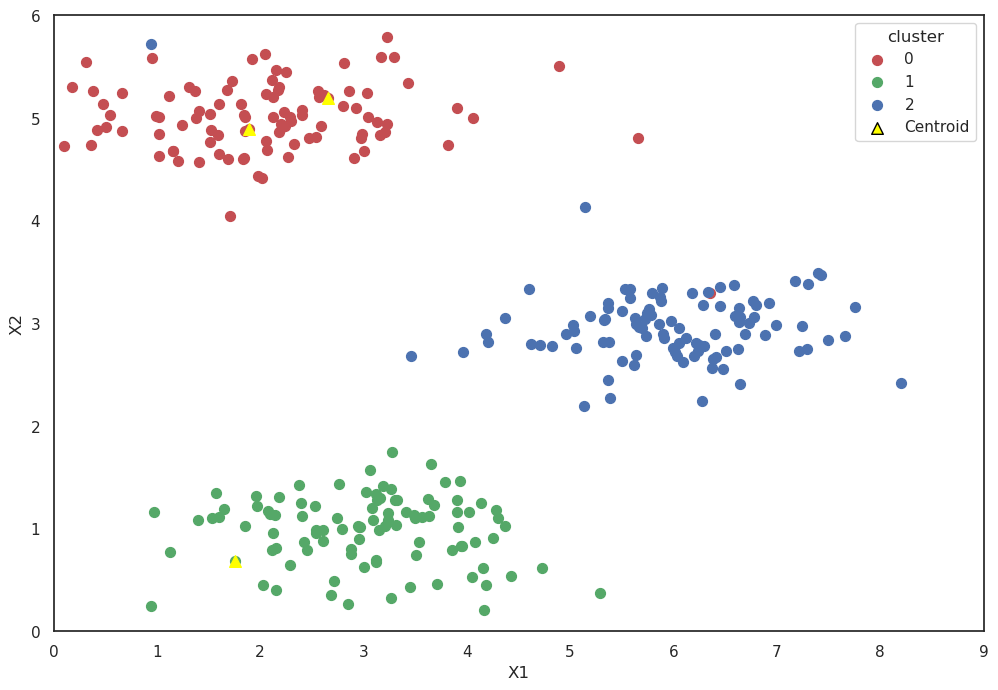

In [12]:
clusters, centroids, start, end = kmenas(X, 3, show_start=True)

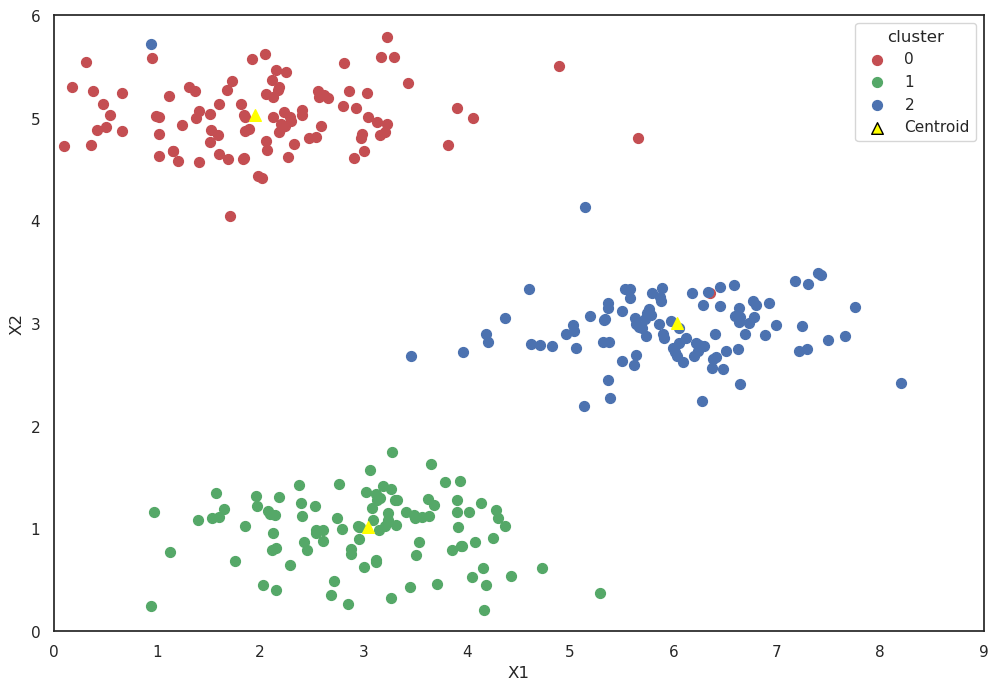

In [13]:
draw_init_cluster(clusters)

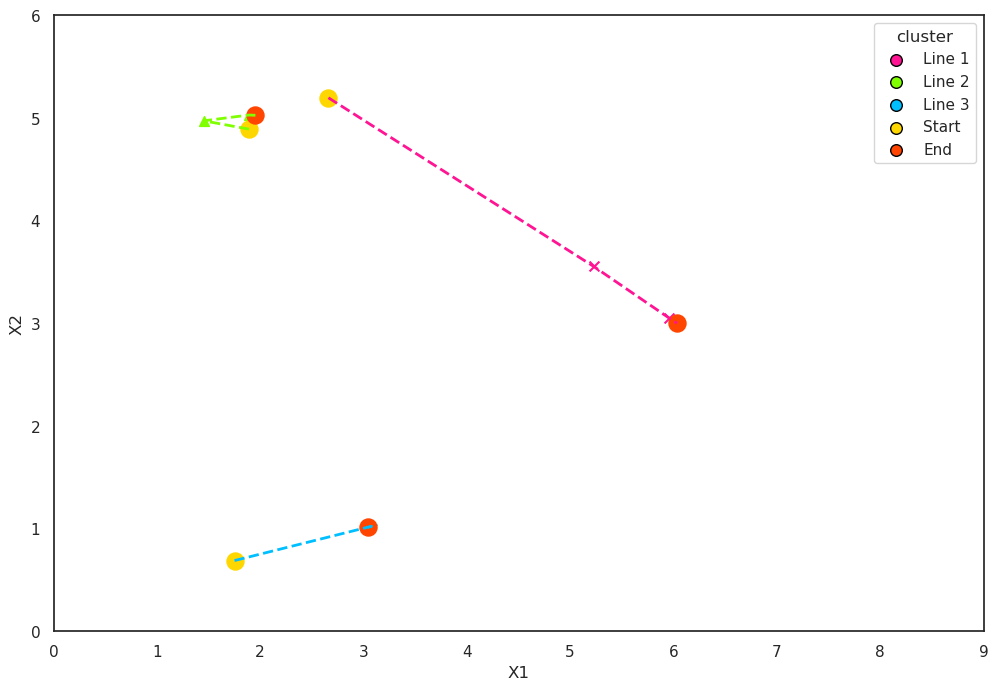

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#FF1493', '#7FFF00', '#00BFFF']
markers = ['x', '^', '*']
for i in range(3):
    center = centroids[i::3]
    x_coords = [p[0] for p in center]
    y_coords = [p[1] for p in center]
    plt.plot(x_coords, y_coords, '--', linewidth=2, color=colors[i])
    for it in center:
        plt.scatter(it[0],  it[1], s=50, color=colors[i], marker=markers[i])
    plt.scatter([], [], s=70, c=colors[i], edgecolor='black', label=f'Line {i+1}')


# start,end
for it in start:
    plt.scatter(it[0], it[1], color='#FFD700', s=150)
plt.scatter([], [], s=70, c='#FFD700', edgecolor='black', label='Start')

for it in end:
    plt.scatter(it[0], it[1], s=150, c='#FF4500')
plt.scatter([], [], s=70, c='#FF4500', edgecolor='black', label='End')


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_xlim(0, 9)
ax.set_ylim(0, 6)
ax.legend(loc='best', title='cluster')

plt.show()

# Sklearn Kmeans

In [15]:
sk_kmeans = KMeans(n_clusters=3)
sk_kmeans.fit(X);

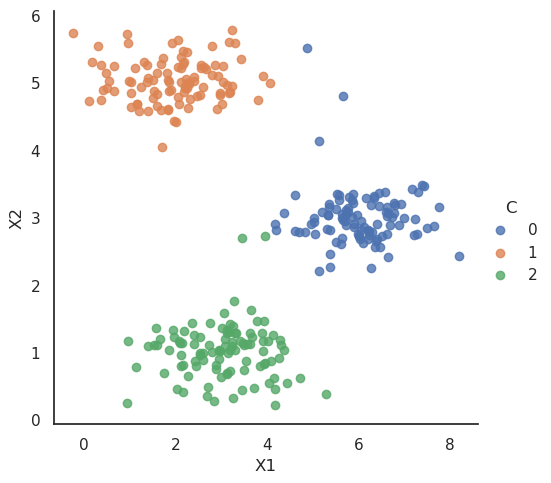

In [16]:
sk_C = sk_kmeans.predict(X)
data_with_C = data.copy()
data_with_C['C'] = sk_C
sns.lmplot(x='X1', y='X2', hue='C', data=data_with_C, fit_reg=False)
plt.show()

#  Image compression with K-means

<img src="data/bird_small.png" style="margin:auto">

In [17]:
image_datas = loadmat('data/bird_small.mat')
image_datas.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A'])

In [18]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = len(centroids)
    idx = np.zeros(m)

    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = distance(X[i], centroids[j])
            if dist < min_dist:
                min_dist = dist
                idx[i] = j

    return idx

In [19]:
A = image_datas['A']
A.shape

(128, 128, 3)

### normalization 归一化处理

大多数神经网络和聚类算法（如K-Means）期望输入数据在 [0, 1] 或 [-1, 1] 范围内，归一化能提升数值稳定性。

In [20]:
A = A / 255.0

# 将数据转化为2D数据(像素 x RGB)
X = A.reshape(A.shape[0] * A.shape[1], A.shape[2])
# X = A.reshape(-1, A.shape[2])
X.shape

(16384, 3)

## use manual kmeans

In [21]:
centroids = kmenas(A, 3)[1]

In [22]:
idx = find_closest_centroids(A, centroids)
idx

array([19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
       19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
       19.,  1.,  1.,  1.,  1.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4., 18., 18., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 12., 12., 12., 12.,  9., 12., 12.,
       12.,  9.,  9.,  6.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,
        3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [34]:
def compress_image(image_path, k_colors=16, max_iter=10):
    # 读取图像并归一化
    pic = io.imread(image_path) / 255.
    h, w, c = pic.shape
    # 将图像转化为2D数组
    pixel_data = pic.reshape(-1, 3)

    # k—means聚类颜色
    clusters, _, _, _ = kmenas(pixel_data, k_colors, max_iter)
    colors = np.array([c['center'] for c in clusters])

    # 为每个像素分配最近的颜色
    compressed_pixels = np.zeros_like(pixel_data)
    for i in range(len(pixel_data)):
        dists = [distance(pixel_data[i], color) for color in colors]
        compressed_pixels[i] = colors[np.argmin(dists)]

    # 重建压缩后的图像
    compressed_image = compressed_pixels.reshape(h, w, c)
    return compressed_image

In [35]:
compressed = compress_image('data/bird_small.png', k_colors=16)

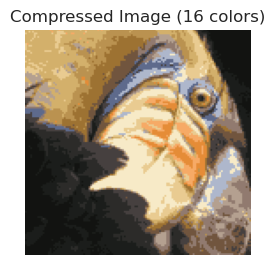

In [36]:
plt.subplot(1, 2, 2)
plt.imshow(compressed)
plt.title(f'Compressed Image (16 colors)')
plt.axis('off')
plt.show()

## use Sklearn.cluster.KMeans

In [41]:
model = KMeans(n_clusters=16, n_init=10)
model.fit(X);

In [43]:
centroids = model.cluster_centers_
C = model.predict(X)

centroids.shape, C.shape

((16, 3), (16384,))

In [44]:
compressed_pic = centroids[C].reshape((128,128,3))

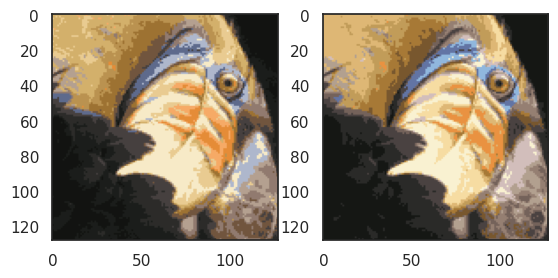

In [46]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(compressed)
ax[1].imshow(compressed_pic)
plt.show()